In [11]:
import os
import torch
import umap.plot
import numpy as np
import pandas as pd
from mord import OrdinalRidge
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, precision_recall_fscore_support, matthews_corrcoef, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from scipy.stats import spearmanr



In [4]:
ge = np.load("/home/bram/jointomicscomp/data/GE.npy")
cancerTypes = np.load("/home/bram/jointomicscomp/data/cancerTypes.npy")
cancerType = np.load("/home/bram/jointomicscomp/data/cancerType.npy")
cancer_type_labels = cancerTypes[cancerType.astype(int)]

In [14]:
# From baseline

def evaluate_classification(y_true, y_pred):
    # returns accuracy, precision, recall, f1, mcc, confusion_matrix
    print(y_true.dtype, y_pred.dtype)

    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    confMat = confusion_matrix(y_true, y_pred)
    # calculate spearman's correlation
    coef, p = spearmanr(y_true, y_pred)

    return [acc, pr, rc, f1, mcc, confMat, coef, p]

In [15]:
print("RAW DATA: Baseline predictions")
alphas = np.array([1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.0, 2.0, 5.0, 10., 20.])

# if criterion == 'acc':
#     ind = 0
# elif criterion == 'pr':
#     ind = 1
# elif criterion == 'rc':
#     ind = 2
# elif criterion == 'f1':
#     ind = 3
# else:
#     assert criterion == 'mcc'
#     ind = 4

latent_train = np.load("/home/bram/jointomicscomp/data/task1/GE_train.npy")
latent_val = np.load("/home/bram/jointomicscomp/data/task1/GE_val.npy")
latent_test = np.load("/home/bram/jointomicscomp/data/task1/GE_test.npy")
y_train = np.load("/home/bram/jointomicscomp/data/task1/cancerType_train.npy").astype(np.float32)
y_val = np.load("/home/bram/jointomicscomp/data/task1/cancerType_val.npy").astype(np.float32)
y_test = np.load("/home/bram/jointomicscomp/data/task1/cancerType_test.npy").astype(np.float32)


validationPerformance = np.zeros(alphas.shape[0])
models = []

for i, a in enumerate(alphas):
    model = RidgeClassifier(alpha=a, fit_intercept=True, normalize=False, random_state=1)

#     model = Ridge(alpha=a, fit_intercept=True, normalize=False, random_state=1)

    # train
    model.fit(latent_train, y_train)

    # save so that we don't have to re-train
    models.append(model)

    # evaluate using user-specified criterion
    validationPerformance[i] = evaluate_classification(y_val, model.predict(latent_val))[0]

bestModel = models[np.argmax(validationPerformance)]

predictions = bestModel.predict(latent_test).astype(int)

classifications1 = evaluate_classification(y_test, predictions)

print("Accuracy : ", classifications1[0])
print("Confusion matrix : \n", classifications1[5])

RAW DATA: Baseline predictions


/home/bram/Documents/anaconda3/envs/vae/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.94751e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


float32 float32


/home/bram/Documents/anaconda3/envs/vae/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.95864e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


float32 float32


/home/bram/Documents/anaconda3/envs/vae/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.06924e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


float32 float32


/home/bram/Documents/anaconda3/envs/vae/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.16755e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


float32 float32
float32 float32
float32 float32
float32 float32
float32 float32
float32 float32
float32 float32
float32 int64
Accuracy :  0.955952380952381
Confusion matrix : 
 [[12  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 40 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  1  0]
 [ 0  0  0 ...  0 41  0]
 [ 0  0  0 ...  0  0  8]]


/home/bram/Documents/anaconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print("Spearman coef : \n", classifications1[6])
print("Spearman p-value : \n", classifications1[7])


Spearman coef : 
 0.9700198427924572
Spearman p-value : 
 0.0


In [7]:
test = bestModel.coef_
z = latent_test
for row in z:
    row = np.multiply(row, test)

In [8]:
title = "LinearSVC Gene Expression Test set"
save_dir = "/home/bram/jointomicscomp/umaps"
save_file = "{}/UMAP {} Raw Data.png"\
    .format(save_dir, "GE")
background = "white"
color_key_cmap = "Spectral"

In [9]:

mapper = umap.UMAP(
            n_neighbors=15,
            min_dist=0.1,
            n_components=2,
            metric='euclidean'
        ).fit(z)


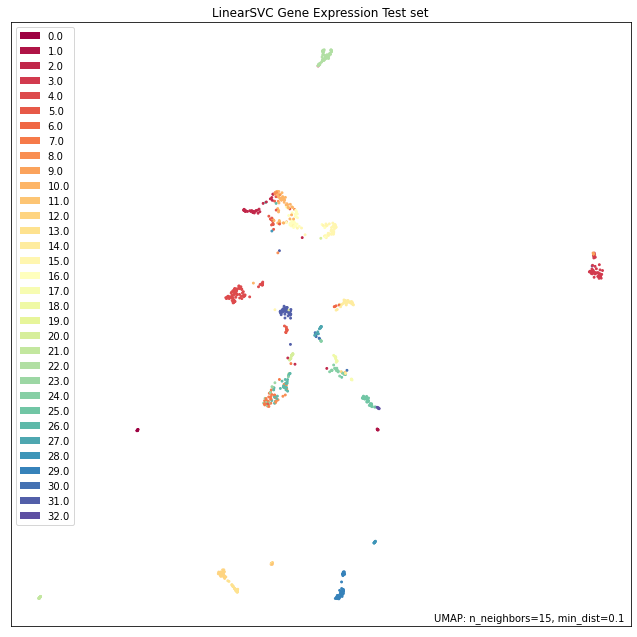

In [10]:
p = umap.plot.points(mapper, labels=y_test, color_key_cmap=color_key_cmap, background=background)
umap.plot.plt.title(title)
# umap.plot.plt.legend()
umap.plot.plt.savefig(save_file, dpi=1600)
umap.plot.plt.show()